# PCSE-Gym-Wofost

Quick notebook to see PCSE-Gym in action for both WOFOST and LINTUL-3

*With the current crop-growth-model parameters the growth curves do not match that well. Need some calibration to align them better. This has been done in the recent past, but is not "implemented" here.*


In [1]:
# Install libraries
!rm -fr /content/PCSE-Gym && cd /content/ && git clone https://github.com/BigDataWUR/PCSE-Gym.git
!cd /content/PCSE-Gym && git switch develop 

!pip3 uninstall -y --quiet pcse
!rm -fr /content/pcse && cd /content/ && git clone https://github.com/ajwdewit/pcse.git
!cd /content/pcse && git switch develop_WOFOST_v8_1  && git apply /content/PCSE-Gym/notebooks/nitrogen-winterwheat/pcse-lintul3.patch && pip3 install --quiet -e .

!pip install setuptools==65.5.0
!pip3 install --quiet --quiet --quiet stable_baselines3
!pip3 install --upgrade --quiet cloudpickle pickle5

import sys
sys.path += ['/content/pcse','/content/PCSE-Gym/','/content/PCSE-Gym/notebooks/nitrogen-winterwheat']

Cloning into 'PCSE-Gym'...
remote: Enumerating objects: 846, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 846 (delta 51), reused 70 (delta 42), pack-reused 756
Receiving objects: 100% (846/846), 291.35 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (314/314), done.
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'
Cloning into 'pcse'...
remote: Enumerating objects: 10508, done.
remote: Counting objects: 100% (439/439), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 10508 (delta 337), reused 324 (delta 288), pack-reused 10069
Receiving objects: 100% (10508/10508), 99.56 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (4865/4865), done.
Updating files: 100% (789/789), done.
Branch 'develop_WOFOST_v8_1' set up to track remote branch 'develop_WOFOST_v8_1' from 'origin'.
Switched to a new branch 'develop_WOFOST_v8_1'
  Preparing metadata (se

In [2]:
from wrapper import ReferenceEnv, get_lintul_kwargs, get_wofost_kwargs
from helper import evaluate_policy, determine_and_log_optimum, FindOptimum, evaluate_policy, plot_variable, get_ylim_dict
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import pcse
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# run CERES on WOFOST and LINTUL "PCSE-Gym-environments"

weather_features = ["IRRAD", "TMIN", "RAIN"]
action_features = []
test_year = 1990
location = (52,5.5)

print('WOFOST')
crop_features_wofost = ["DVS", "TAGP", "LAI", "RNuptake", "TRA", "NAVAIL", "SM", "RFTRA", "TWSO"]
costs_nitrogen_wofost = 1.0 #note that in wofost the unit of N is kg/ha
env_wofost = ReferenceEnv(crop_features=crop_features_wofost, action_features=action_features, weather_features=weather_features,
                        costs_nitrogen=costs_nitrogen_wofost, years=test_year, locations=location, **get_wofost_kwargs())
env_wofost = VecNormalize(DummyVecEnv([lambda: env_wofost]), norm_obs=True, norm_reward=True, clip_obs=10., clip_reward=50., gamma=1)
optimizer_wofost = FindOptimum(env_wofost) # CERES: optimized on the test year
optimum_wofost = optimizer_wofost.optimize_start_dump(bounds=(0, 1000.0))

print('LINTUL')
crop_features_lintul = ["DVS", "TGROWTH", "LAI", "NUPTT", "TRAN", "TNSOIL", "TRAIN", "TRANRF", "WSO"]
costs_nitrogen_lintul = 10.0 #note that in wofost the unit of N is g/m2 (e.g. 23 g/m2 = 230kg/ha)
env_lintul = ReferenceEnv(crop_features=crop_features_lintul, action_features=action_features, weather_features=weather_features,
                        costs_nitrogen=costs_nitrogen_lintul, years=test_year, locations=location, **get_lintul_kwargs())
env_lintul = VecNormalize(DummyVecEnv([lambda: env_lintul]), norm_obs=True, norm_reward=True, clip_obs=10., clip_reward=50., gamma=1)
optimizer_lintul = FindOptimum(env_lintul) # CERES: optimized on the test year
optimum_lintul = optimizer_lintul.optimize_start_dump(bounds=(0, 100.0))

WOFOST
optimum found for [1990] at [221.59222] [527.48865]
- 1990 [527.48846]
LINTUL
optimum found for [1990] at [22.89154] [136.55603]
- 1990 [136.55603]


WOFOST
LINTUL
Available variables: ['DVS', 'LAI', 'TAGP', 'TWSO', 'TWLV', 'TWST', 'WRT', 'TRA', 'RD', 'SM', 'WWLOW', 'RFTRA', 'NAVAIL', 'Ndemand', 'RNuptake', 'NuptakeTotal', 'NamountSO', 'NamountLV', 'NamountST', 'NamountRT', 'IRRAD', 'TMIN', 'TMAX', 'VAP', 'RAIN', 'E0', 'ES0', 'ET0', 'WIND', 'action', 'fertilizer', 'reward', 'growth', 'NUPTT']


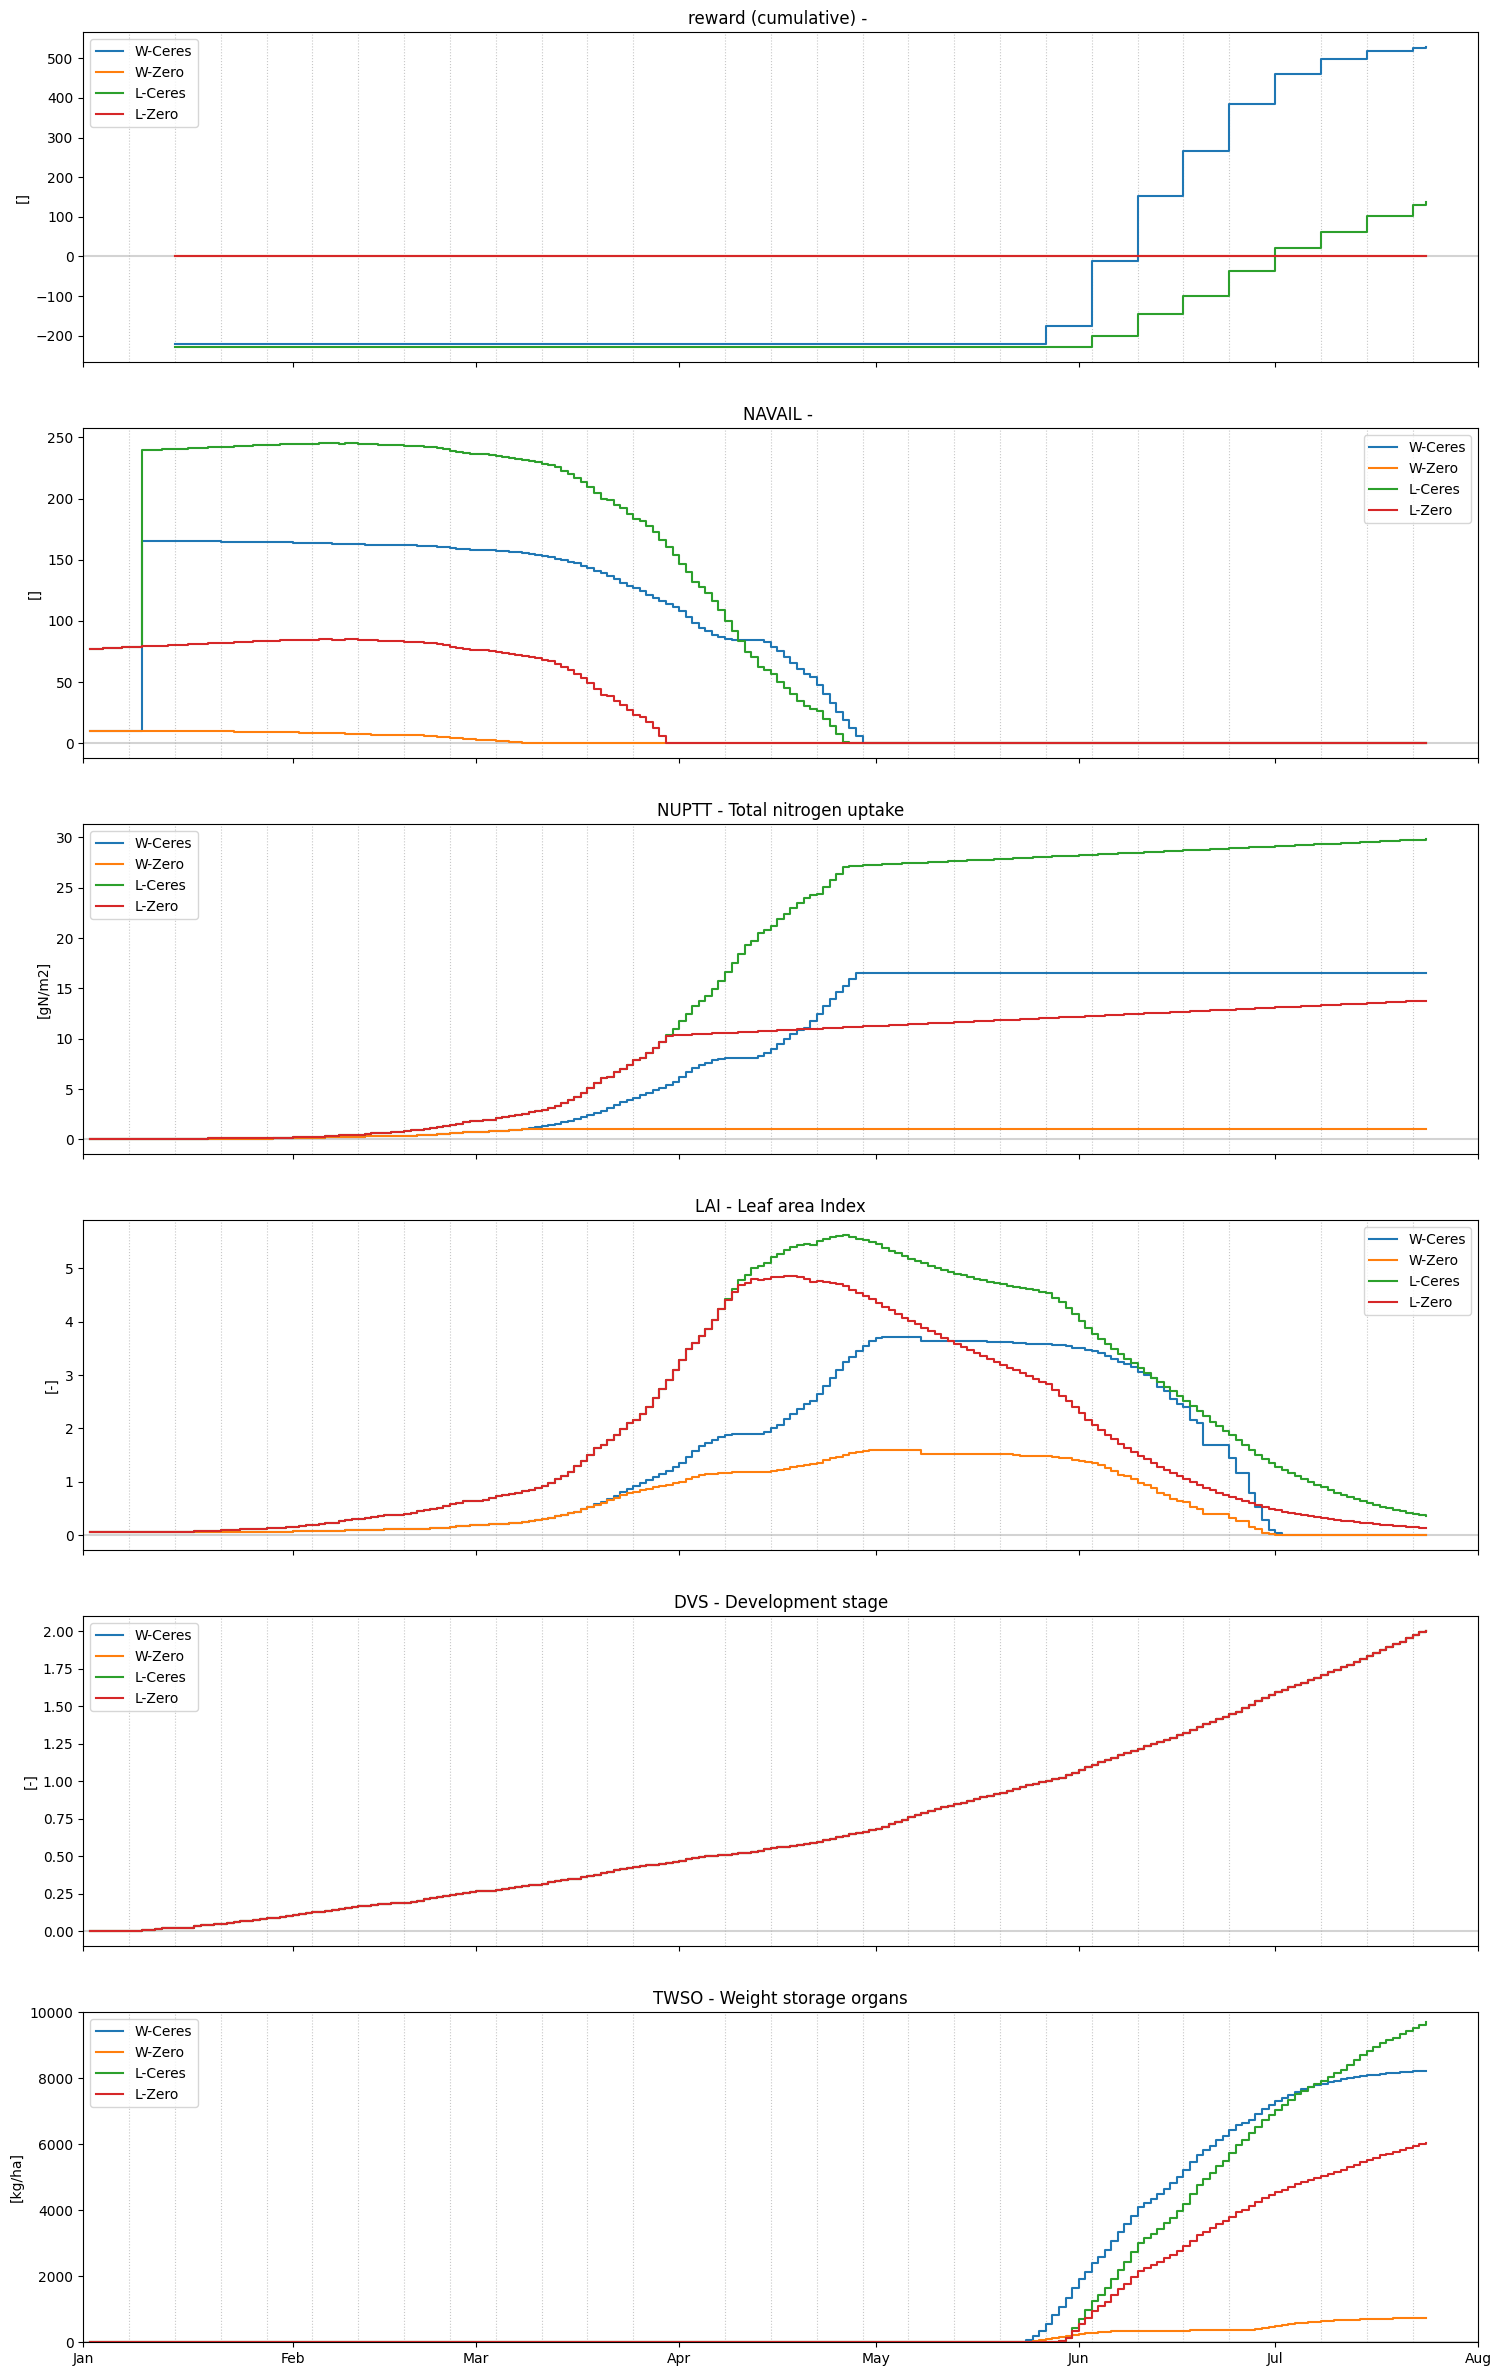

In [5]:
print('WOFOST')
rewards_opt_wofost, results_opt_wofost = evaluate_policy('start-dump', env_wofost, amount=optimum_wofost)
rewards_zero_wofost, results_zero_wofost = evaluate_policy('start-dump', env_wofost, amount=0)

#TODO: put this in a function
k = list(results_opt_wofost[0]["RNuptake"].keys())
v = 0.1*np.cumsum(list(results_opt_wofost[0]["RNuptake"].values()))
results_opt_wofost[0]["NUPTT"] = dict(zip(k, v))
k = list(results_zero_wofost[0]["RNuptake"].keys())
v = 0.1*np.cumsum(list(results_zero_wofost[0]["RNuptake"].values()))
results_zero_wofost[0]["NUPTT"] = dict(zip(k, v))


print('LINTUL')
rewards_opt_lintul, results_opt_lintul = evaluate_policy('start-dump', env_lintul, amount=optimum_lintul)
rewards_zero_lintul, results_zero_lintul = evaluate_policy('start-dump', env_lintul, amount=0)

#TODO: put this in a function
results_opt_lintul[0]["TWSO"] = {x: y*10 for x, y in results_opt_lintul[0]["WSO"].items()}
results_opt_lintul[0]["NAVAIL"] = {x: y*10 for x, y in results_opt_lintul[0]["TNSOIL"].items()}
results_zero_lintul[0]["TWSO"] = {x: y*10 for x, y in results_zero_lintul[0]["WSO"].items()}
results_zero_lintul[0]["NAVAIL"] = {x: y*10 for x, y in results_zero_lintul[0]["TNSOIL"].items()}

results_subset = {'W-Ceres': results_opt_wofost, 'W-Zero': results_zero_wofost, 
                  'L-Ceres': results_opt_lintul,  'L-Zero': results_zero_lintul}
all_variables = list(list(results_subset.values())[0][0].keys())
print(f'Available variables: {all_variables}')

plot_variables =  ['reward', 'NAVAIL', 'NUPTT', 'LAI', 'DVS', 'TWSO'] #, 'RNuptake', 'NAVAIL' 'TWSO',]
plot_average = False
figsize = (3*len(plot_variables), 5*len(plot_variables))
fig, axes = plt.subplots(len(plot_variables), 1, sharex=True, figsize=figsize)  
for i, variable in enumerate(plot_variables):
    ax = axes if len(plot_variables) == 1 else axes[i]
    plot_variable(results_subset, variable=variable, cumulative_variables = ['fertilizer', 'reward', 'IRRAD','RAIN', 'RNuptake'], ax=ax, ylim=get_ylim_dict()[variable], plot_average=plot_average, put_legend=True)